### Libraries

In [1]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
import weakref
import gc
#from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report
from torch import nn
import torch.nn.functional as F
import types
from transformers.modeling_outputs import SemanticSegmenterOutput
from enum import Enum
from torchvision import transforms
import nibabel as nib
from pathlib import Path
import math
from collections import defaultdict
from medsyn.tasks import (
    CutPastePatchBlender,
    SmoothIntensityChangeTask,
    GaussIntensityChangeTask,

    SinkDeformationTask,
    SourceDeformationTask,
    IdentityTask,
)
from transformers import UperNetForSemanticSegmentation, AutoImageProcessor
from torchinfo import summary
import yaml
from easydict import EasyDict
import math
import argparse
import warnings
from utils.misc_helper import (
    AverageMeter,
    compute_imagewise_metrics,
    compute_pixelwise_metrics,
    get_current_time,
    create_logger,
    set_seed
)
from utils.losses import FocalLoss, BinaryDiceLoss

import pprint
from tqdm import tqdm
import multiprocessing
import numpy as np
import random
from pathlib import Path
import json

/home/matteomorellini/boh/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch.utils.data as data
from torch.utils.data import Dataset, random_split, DataLoader, Subset
from PIL import Image
from pathlib import Path
from collections import defaultdict

In [3]:
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, create_test_image_3d
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, ResNet
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.8.0+cu128
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /home/<username>/boh/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 11.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.23.0+cu128
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.1.0
pandas version: 2.3.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.57.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For det

### Original model

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
num_workers = max(1, multiprocessing.cpu_count() - 1) 

In [10]:
model = UperNetForSemanticSegmentation.from_pretrained(
    "openmmlab/upernet-swin-base"
)

processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
summary(model, input_size=(8, 3, 512, 512))  # (B,C,H,W)

Layer (type:depth-idx)                                            Output Shape              Param #
UperNetForSemanticSegmentation                                    [8, 150, 512, 512]        --
├─SwinBackbone: 1-1                                               [8, 128, 128, 128]        --
│    └─SwinEmbeddings: 2-1                                        [8, 16384, 128]           --
│    │    └─SwinPatchEmbeddings: 3-1                              [8, 16384, 128]           6,272
│    │    └─LayerNorm: 3-2                                        [8, 16384, 128]           256
│    │    └─Dropout: 3-3                                          [8, 16384, 128]           --
│    └─SwinEncoder: 2-2                                           [8, 128, 128, 128]        --
│    │    └─ModuleList: 3-4                                       --                        86,870,008
│    └─ModuleDict: 2-3                                            --                        --
│    │    └─LayerNorm: 3-5       

In [12]:
num_classes = 2

# Replace the final classifier
model.decode_head.classifier = nn.Conv2d(
    in_channels=model.decode_head.classifier.in_channels,
    out_channels=num_classes,
    kernel_size=1
)

model.to(device);
#summary(model, input_size=(8, 3, 224, 224))

# REMEMBER: UperNetHead is the actual head, UperNetFCNHead is used only during training
# to check whether compression is working

In [13]:
def new_forward(self, pixel_values=None, output_hidden_states=None, return_dict=True, **kwargs):
    # get input shape
    input_shape = pixel_values.shape if pixel_values is not None else None
    # run backbone + head
    outputs = self.backbone(pixel_values)
    feats = outputs.feature_maps

    logits = self.decode_head(feats)


    # fix interpolation: only use H, W
    if input_shape is not None:
        h, w = input_shape[-2:]
        logits = F.interpolate(logits, size=(h, w),
                               mode="bilinear", align_corners=False)
    return SemanticSegmenterOutput(logits=logits)

model.forward = types.MethodType(new_forward, model)


In [14]:
img3d, mask3d = create_test_image_3d(64, 64, 64, num_seg_classes=2, channel_dim=0)

img3d = torch.tensor(img3d)   # [1, 64, 64, 64]
mask3d = torch.tensor(mask3d)

slice_idx = 32
img2d = img3d[0, slice_idx].unsqueeze(-1).repeat(1, 1, 3).numpy()  # duplicates the last dimension 3 times -> fake RGB
# because UPerNet expects a 3-channel RGB input

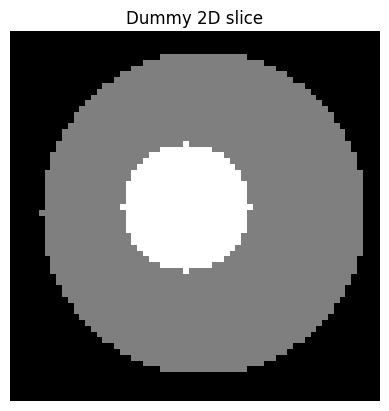

In [15]:
plt.imshow(img2d.astype("float32"), cmap="gray")  # or just plt.imshow(img2d) since it's RGB
plt.title("Dummy 2D slice")
plt.axis("off")
plt.show()

In [16]:
mask2d = mask3d[0, slice_idx].unsqueeze(-1).repeat(1, 1, 3).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


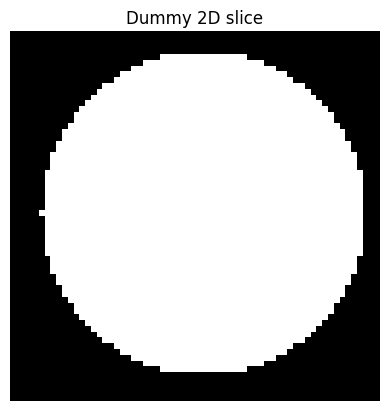

In [17]:
plt.imshow(mask2d.astype("float32"), cmap="gray")
plt.title("Dummy 2D slice")
plt.axis("off")
plt.show()

In [18]:
# pre-process into the tensor-shape and normalization that the model expects
inputs = processor(images=img2d, return_tensors="pt")

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [19]:
inputs['pixel_values'].shape

torch.Size([1, 3, 512, 512])

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs.to(device);

In [21]:
model.to(device)  # moves all params/buffers

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits  # [1, num_classes, H', W']

In [22]:
# 6. Resize back to original size
seg = processor.post_process_semantic_segmentation(outputs, target_sizes=[img2d.shape[:2]])
seg = seg[0].cpu().numpy()

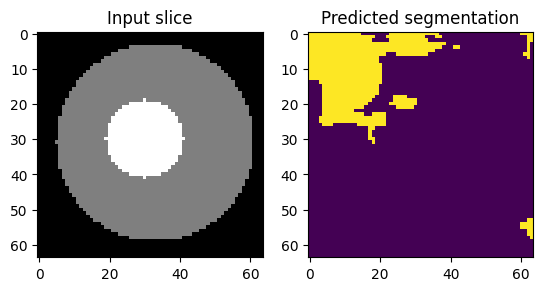

In [23]:
# 7. Visualize
plt.subplot(1,2,1)
plt.imshow(img2d); plt.title("Input slice")
plt.subplot(1,2,2)
plt.imshow(seg, cmap="viridis"); plt.title("Predicted segmentation")
plt.show()

In [24]:
# Access backbone
backbone = model.backbone  # this is SwinModel

# Access patch embedding
print(backbone.embeddings)

SwinEmbeddings(
  (patch_embeddings): SwinPatchEmbeddings(
    (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
)


In [25]:
type(inputs)

transformers.image_processing_base.BatchFeature

### Modify to 3D input

In [26]:
def preprocess_3d_volume(volume, depth_size=5, stride=1, mean=None, std=None):
    """
    volume: torch.Tensor [C,D,H,W] or [D,H,W] if single-channel
    depth_size: number of slices per window
    stride: step along depth
    """
    if volume.ndim == 3:
        volume = volume.unsqueeze(0)  # [1,D,H,W]

    C, D, H, W = volume.shape
    windows = []
    for start in range(0, D - depth_size + 1, stride):
        clip = volume[:, start:start+depth_size, :, :]  # [C, depth_size, H, W]

        # normalize like processor (ImageNet mean/std per channel)
        if mean is not None and std is not None:
            for c in range(C):
                clip[c] = (clip[c] - mean[c]) / std[c]

        windows.append(clip)

    # [num_windows, C, depth_size, H, W]
    return torch.stack(windows)


In [27]:
vol = torch.randn(1, 20, 224, 224)  # [C=1, D=20, H,W]
windows = preprocess_3d_volume(vol, depth_size=5, stride=5)
print(windows.shape)  # [num_windows, 1, 5, 224, 224]
# non-overlapping windows due to stride = depth_size

torch.Size([4, 1, 5, 224, 224])


In [28]:
class Conv3dPatchEmbed(nn.Module):
    def __init__(self, in_chans=1, embed_dim=128,
                 kernel_size=(5,4,4), stride=(5,4,4), pretrained_weights = None, pretrained_bias = None):
        super().__init__()
        self.proj = nn.Conv3d(in_chans, embed_dim,
                              kernel_size=kernel_size,
                              stride=stride)
        nn.init.zeros_(self.proj.weight)
        middle_layer = kernel_size[0] // 2
        self.proj.weight.data[:, 0, middle_layer, :, :] = pretrained_weights[:, 0, :, :] + pretrained_weights[:, 1, :, :] + pretrained_weights[:, 2, :, :]

        self.proj.bias.data = pretrained_bias.clone()


    def forward(self, x):                     # x: [B,C,D,H,W]
        x = self.proj(x)                      # [B,embed_dim,D',H',W']
        # IMPORTANT: UPerNet/Swin is 2D downstream. Ensure D'==1, then squeeze.
        if x.shape[2] != 1:
            raise ValueError(f"Depth after Conv3d must be 1 to squeeze, got {x.shape[2]}. "
                             "Fix kernel/stride/padding or handle 3D downstream.")
        x = x[:, :, 0, :, :]                  # [B,embed_dim,H',W']
        return x

In [29]:
def make_patch_embeddings_3d(embeddings: nn.Module, conv3d_embedder: nn.Module):
    # Create a weak reference (non-owning) to the parent embeddings object
    # This avoids circular references and ensures `embeddings` is not kept alive
    parent_ref = weakref.proxy(embeddings)

    # Access the original patch embedding layer from the parent (e.g., SwinEmbeddings.patch_embeddings)
    base = embeddings.patch_embeddings

    # Extract the patch_size attribute if it exists, otherwise default to (4,4)
    # Note: only primitives like tuples/ints are copied, not layers
    patch_size = getattr(base, "patch_size", (4,4))

    # Define a nested class to replace the original patch embedding with a 3D version
    class PatchEmbeddings3D(nn.Module):
        def __init__(self):
            super().__init__()
            # Register the custom 3D convolutional embedder (the actual learnable child module)
            self.conv3d = conv3d_embedder

            # Keep track of patch size as a primitive attribute (safe to copy)
            self.patch_size = patch_size

        def forward(self, pixel_values_5d: torch.Tensor):
            # Enforce 5D input: [Batch, Channels, Depth, Height, Width]
            if pixel_values_5d.ndim != 5:
                raise ValueError(f"Expected [B,C,D,H,W], got {tuple(pixel_values_5d.shape)}")

            # Apply the 3D convolution to produce embeddings
            # Output shape will be [B, C, H', W'] (depth collapsed by conv stride/kernel)
            x = self.conv3d(pixel_values_5d)
            B, C, H, W = x.shape

            # If the parent embeddings module has a normalization layer, apply it
            # Hugging Face convention: flatten spatial dims, apply LN(C), then reshape
            if getattr(parent_ref, "norm", None) is not None:
                x_flat = x.flatten(2).transpose(1, 2)   # [B, H'*W', C]
                x_flat = parent_ref.norm(x_flat)        # apply LayerNorm on channel dim
                # Optionally could reshape back to [B, C, H', W'], but here kept flattened
                x = x_flat

            # Return embeddings and the resulting spatial resolution (H', W')
            return x, (H, W)

    # Instantiate and return the new PatchEmbeddings3D module
    return PatchEmbeddings3D()


In [30]:
conv2d = model.backbone.embeddings.patch_embeddings.projection
W2d = conv2d.weight.data
b2d = conv2d.bias.data

In [31]:
conv3d_embed = Conv3dPatchEmbed(
    in_chans=1,
    embed_dim=128,         # must match Swin config
    kernel_size=(5,4,4),
    stride=(5,4,4),
    pretrained_weights=W2d,
    pretrained_bias=b2d
)

In [32]:
# Replace the entire patch_embeddings module with the 3D-aware wrapper
model.backbone.embeddings.patch_embeddings = make_patch_embeddings_3d(
    model.backbone.embeddings,
    conv3d_embed
)

In [33]:
model.backbone.embeddings

SwinEmbeddings(
  (patch_embeddings): PatchEmbeddings3D(
    (conv3d): Conv3dPatchEmbed(
      (proj): Conv3d(1, 128, kernel_size=(5, 4, 4), stride=(5, 4, 4))
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [34]:
# 4) Test
x = torch.randn(2, 1, 5, 224, 224).to(device)  # [B,C,D,H,W]; D=5 fits kernel=(5,...) with stride=(5,...)
model.to(device)
tokens, (H, W) = model.backbone.embeddings.patch_embeddings(x)
print(tokens.shape, (H, W))
# Expected: tokens -> [B, embed_dim, H', W'], (H', W') consistent with stride

torch.Size([2, 3136, 128]) (56, 56)


In [35]:
model.backbone.embeddings.patch_embeddings.conv3d.proj.weight[0]

tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0010,  0.0752, -0.1624, -0.2067],
          [ 0.0497,  0.2111,  0.0617,  0.1348],
          [-0.0512, -0.0140,  0.0711,  0.0239],
          [-0.1518, -0.0956, -0.0805,  0.0813]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]]], device='cuda:0',
       grad_

In [36]:
x = torch.randn(2, 1, 5, 224, 224).to(device)  # [B,C,D,H,W]
tokens, (H, W) = model.backbone.embeddings.patch_embeddings(x)
normalized_tokens = model.backbone.embeddings.norm(tokens)
dropout_tokens = model.backbone.embeddings.dropout(normalized_tokens)

In [37]:
class SwinEmbeddings3D(nn.Module):
    def __init__(self, patch_embeddings3d, embed_dim, p_drop=0.0):
        super().__init__()
        self.patch_embeddings = patch_embeddings3d     # your Conv3dPatchEmbed
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):                              # x: [B,C,D,H,W]
        if x.ndim != 5:
            raise ValueError(f"Expected 5D, got {x.shape}")
        tokens, (H, W) = self.patch_embeddings(x)   # tokens: [B, N, C], N=D*H*W
        tokens = self.norm(tokens)
        tokens = self.dropout(tokens)
        return tokens, (H, W)

emb3d = SwinEmbeddings3D(
    patch_embeddings3d=model.backbone.embeddings.patch_embeddings,  # your Conv3d block
    embed_dim=128,
    p_drop=0.0,
)
model.backbone.embeddings = emb3d

In [38]:
model.backbone.embeddings

SwinEmbeddings3D(
  (patch_embeddings): PatchEmbeddings3D(
    (conv3d): Conv3dPatchEmbed(
      (proj): Conv3d(1, 128, kernel_size=(5, 4, 4), stride=(5, 4, 4))
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [39]:
x = torch.randn(2, 1, 5, 224, 224).to(device)  # [B,C,D,H,W]
model.to(device)
embedded = model.backbone.embeddings(x) # where embedded[0] is the actual embeddings, embedded[1] is (#patches_x, #patches_y)

In [40]:
embedded[0].shape, embedded[1]

(torch.Size([2, 3136, 128]), (56, 56))

In [41]:
x = torch.randn(1, 1, 5, 512, 512).to(device)  # [B,C,D,H,W]
tokens, (H, W) = model.backbone.embeddings(x)  # embedding returns both

In [42]:
tokens.shape

torch.Size([1, 16384, 128])

In [43]:
print(tokens.shape, H , W)

torch.Size([1, 16384, 128]) 128 128


In [44]:
encoded = model.backbone.encoder(tokens, (H, W))

In [45]:
bb_out = model.backbone(pixel_values=x)     # ← correct entry point
feats = bb_out.feature_maps

In [46]:
len(feats)

4

In [47]:
model.decode_head

UperNetHead(
  (classifier): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
  (psp_modules): UperNetPyramidPoolingModule(
    (0): UperNetPyramidPoolingBlock(
      (0): AdaptiveAvgPool2d(output_size=1)
      (1): UperNetConvModule(
        (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
    )
    (1): UperNetPyramidPoolingBlock(
      (0): AdaptiveAvgPool2d(output_size=2)
      (1): UperNetConvModule(
        (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
    )
    (2): UperNetPyramidPoolingBlock(
      (0): AdaptiveAvgPool2d(output_size=3)
      (1): UperNetConvModule(
        (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
       

In [48]:
logits = model.decode_head(feats)
print(logits.shape)
logits = F.interpolate(logits, size=x.shape[-2:], mode="bilinear", align_corners=False)
print(logits.shape)

torch.Size([1, 2, 128, 128])
torch.Size([1, 2, 512, 512])


In [49]:
model.auxiliary_head

UperNetFCNHead(
  (convs): Sequential(
    (0): UperNetConvModule(
      (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
  )
  (classifier): Conv2d(256, 150, kernel_size=(1, 1), stride=(1, 1))
)

In [50]:
logits_aux = model.auxiliary_head(feats)

In [51]:
logits_aux.shape

torch.Size([1, 150, 32, 32])

### Normalization

In [87]:
"""
Windowed 3D preprocessing exactly like the paper:
- Build K-slice windows (e.g., K=5) along depth
- Apply ONE set of spatial augments jointly to all K slices
- CT normalization: clip [-175,250] -> scale to [-1,1]
- Return tensors shaped [B, 1, K, 512, 512] (B handled by DataLoader)
- Target is the CENTER slice mask only
"""

from typing import List, Tuple, Optional
import torchvision.transforms.functional as TF

# -----------------------
# Utility: normalization
# -----------------------
def normalize_ct_window(x: torch.Tensor, clip_min=-175.0, clip_max=250.0) -> torch.Tensor:
    """
    x: float tensor [K,H,W] (values in HU)
    -> clip to [clip_min, clip_max], map to [-1,1]
    """
    x = x.clamp_(clip_min, clip_max)
    x = (x - clip_min) / (clip_max - clip_min)  # [0,1]
    x = x * 2.0 - 1.0                           # [-1,1]
    return x

def normalize_mri_window(x: torch.Tensor) -> torch.Tensor:
    """
    x: float tensor [K,H,W] (non-negative)
    -> map [0, max] to [-1,1]

    
    Normalize MRI intensities to [-1, 1].

    Assumes non-negative input. Scales values relative to the maximum
    intensity found in the window.

    Args:
        x (torch.Tensor): Input tensor of shape [K, H, W] representing
            a stack of K slices from an MRI scan (float, non-negative).

    Returns:
        torch.Tensor: Normalized tensor with same shape [K, H, W],
        values in [-1, 1].
    """
    maxval = x.max().clamp(min=1e-6)
    x = x / maxval * 2.0 - 1.0
    return x

# -----------------------
# Utility: spatial ops (shared params for all K slices + center mask)
# -----------------------
def random_zoom_crop_pad(
    imgK: torch.Tensor,          # [K,H,W], float
    msk: Optional[torch.Tensor], # [H,W] or None
    out_hw: Tuple[int,int]=(512, 512),
    zoom_range: Tuple[float,float]=(0.5, 2.8),  # allow zoom > 2.133 so cropping is possible for 240->512
    p_crop: float = 0.5,         # probability to *aim* for a crop (zoom-in)
    p_apply: float = 1.0,
    rng: Optional[random.Random] = None,
    visualization: bool = False,
):
    """
    Returns: (imgK_out[K,512,512], msk_out[512,512] or None), guaranteeing 512x512 output.
    """
    if rng is None:
        rng = random

    H, W = imgK.shape[-2:]
    outH, outW = out_hw

    if rng.random() > p_apply:
        # Deterministic resize to target size
        imgK = TF.resize(imgK, out_hw, interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
        if msk is not None:
            msk = TF.resize(msk.unsqueeze(0).float(), out_hw, interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()
        return imgK, msk

    # min zoom that enables cropping to out_hw
    z_needed = max(outH / H, outW / W)  # e.g., 512/240 ≈ 2.133

    z_lo, z_hi = zoom_range
    if rng.random() < p_crop:
        # Force zoom-in region so crop is possible
        z = rng.uniform(max(z_lo, z_needed), max(z_hi, z_needed * 1.1))
    else:
        # Stay below crop threshold to trigger pad
        upper = min(z_hi, max(1.0, z_needed) - 1e-6)
        lower = min(z_lo, upper)
        if lower >= upper:         # fallback if originals already big
            lower, upper = z_lo, min(z_hi, 1.0)
        z = rng.uniform(lower, upper)

    newH, newW = max(1, int(round(H * z))), max(1, int(round(W * z)))

    # Resize
    imgK = TF.resize(imgK, (newH, newW), interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
    if msk is not None:
        msk = TF.resize(msk.unsqueeze(0).float(), (newH, newW), interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()

    # Crop or pad, but output is ALWAYS 512x512
    if newH >= outH and newW >= outW:
        # Random crop
        print('CROP')
        if visualization: print(f"CROP z={z:.3f}: {newH}x{newW} -> {outH}x{outW}")
        i = rng.randint(0, newH - outH)
        j = rng.randint(0, newW - outW)
        imgK = imgK[:, i:i+outH, j:j+outW]
        if msk is not None:
            msk = msk[i:i+outH, j:j+outW]
    else:
        # Center pad
        if visualization: print(f"PAD  z={z:.3f}: {newH}x{newW} -> {outH}x{outW}")
        pt = max(0, (outH - newH) // 2); pb = max(0, outH - newH - pt)
        pl = max(0, (outW - newW) // 2); pr = max(0, outW - newW - pl)
        # Fill with a low percentile to avoid bright borders
        flat = imgK.flatten()
        k = max(0, int(0.01 * flat.numel()))
        fill_val = flat.kthvalue(k+1).values.item() if flat.numel() else 0.0
        imgK = F.pad(imgK, (pl, pr, pt, pb), mode="constant", value=float(fill_val))
        if msk is not None:
            msk = F.pad(msk, (pl, pr, pt, pb), mode="constant", value=0)

    # Final assert (optional)
    # imgK.shape == [K, 512, 512]; msk == [512, 512] or None
    return imgK, msk

def random_flip_rotate(
    imgK: torch.Tensor,          # [K,H,W]
    msk: Optional[torch.Tensor], # [H,W]
    p_flip=0.1,
    p_rot=0.1,
    max_degrees=10.0,
    rng: Optional[random.Random] = None,
    visualization: bool = False
):
    """
    Apply random horizontal/vertical flips and small rotations.

    Args:
        imgK (torch.Tensor): Tensor of shape [K, H, W], float, image slices.
        msk (Optional[torch.Tensor]): Center-slice mask [1, H, W] or None.
        p_flip (float): Probability of applying horizontal/vertical flip. Default 0.1.
        p_rot (float): Probability of applying rotation. Default 0.1.
        max_degrees (float): Maximum rotation angle in degrees. Default 10.0.
        rng (Optional[random.Random]): RNG instance. Default: Python `random`.

    Returns:
        Tuple[torch.Tensor, Optional[torch.Tensor]]:
            - Flipped/rotated image [K, H, W]
            - Flipped/rotated mask [H, W] or None
    """

    augmentations_applied = []

    if rng is None:
        rng = random

    # Horizontal flip
    if rng.random() < p_flip:
        augmentations_applied.append('horizontal flip')
        imgK = TF.hflip(imgK)
        if msk is not None:
            msk = TF.hflip(msk)

    # Vertical flip
    if rng.random() < p_flip:
        augmentations_applied.append('vertical flip')
        imgK = TF.vflip(imgK)
        if msk is not None:
            msk = TF.vflip(msk)

    # Small rotation
    if rng.random() < p_rot:
        angle = rng.uniform(-max_degrees, max_degrees)
        augmentations_applied.append(f'rotation {angle:.1f} deg')
        flat = imgK.flatten()
        k = max(0, int(0.01 * flat.numel()) - 1)
        fill_val = flat.kthvalue(k+1).values  # kthvalue is 1-indexed
        imgK = TF.rotate(imgK, angle=angle, interpolation=TF.InterpolationMode.BILINEAR, fill=float(fill_val))
        if msk is not None:
            msk = TF.rotate(msk.unsqueeze(0), angle=angle, interpolation=TF.InterpolationMode.NEAREST, fill=0).squeeze(0)

    joint_str = ', '.join(augmentations_applied) if augmentations_applied else None
    if joint_str is not None and visualization:
        print(f'Augmentation applied: {joint_str}')

    return imgK, msk


def random_intensity_shift(
    imgK: torch.Tensor,  # [K,H,W], in [-1,1]
    p=0.5,
    magnitude=0.1,
    rng: Optional[random.Random] = None,
    visualization: bool = False
):
    """
    Apply random additive intensity shift to [-1, 1]-normalized image window.

    Args:
        imgK (torch.Tensor): Input tensor [K, H, W], float, values in [-1, 1].
        p (float): Probability of applying shift. Default 0.5.
        magnitude (float): Maximum absolute shift. Default 0.1.
        rng (Optional[random.Random]): RNG instance. Default: Python `random`.

    Returns:
        torch.Tensor: Shifted tensor, clamped back to [-1, 1].
    """
    if rng is None:
        rng = random
    if rng.random() < p:
        delta = rng.uniform(-magnitude, magnitude)
        if visualization: print(f'Intensity shift applied: {delta:.3f}')
        imgK = (imgK + delta).clamp_(-1.0, 1.0)
    return imgK


### Dataset

In [61]:
from typing import Dict, List, Any

def sample_per_slice(data_to_iterate: Dict[Any, List[Any]], k_shot: int) -> List[Any]:
    """
    Randomly samples `k_shot` elements from each list of values contained in a dictionary.

    For every key in `data_to_iterate`, this function draws `k_shot` random, non-repeating
    samples from the list associated with that key and concatenates all samples into a
    single output list. If any list contains fewer than `k_shot` elements, a ValueError
    is raised.

    Parameters
    ----------
    data_to_iterate : dict[Any, list[Any]]
        A dictionary where each key maps to a list (or iterable) of sampleable elements.
    k_shot : int
        Number of elements to randomly sample from each list.

    Returns
    -------
    list[Any]
        A flattened list containing all sampled elements across all keys.

    Raises
    ------
    ValueError
        If any list under a given key has fewer than `k_shot` elements.
    """
    for key in data_to_iterate.keys():
        values = data_to_iterate[key]
        if len(values) < k_shot:
            raise ValueError(f"Not enough elements to sample {k_shot} from key {key}")
        data_to_iterate[key] = random.sample(values, k_shot)
    return data_to_iterate

In [62]:
%matplotlib inline

In [63]:
def plot_augmentations(
    image: torch.Tensor,          # [H,W]
    middle_mask: torch.Tensor, # [H,W]
):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Left: original image
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis("off")

    # Right: corresponding mask
    axes[1].imshow(middle_mask.cpu().numpy(), cmap="gray", interpolation="nearest")
    axes[1].set_title(f"Mask (max={middle_mask.max().item()} min={middle_mask.min().item()})")
    axes[1].axis("off")

    axes[2].imshow(image)
    axes[2].imshow(middle_mask.cpu().numpy(), cmap="jet", alpha=0.4)
    axes[2].set_title("Image + Mask overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

In [80]:
class BratsDataset(data.Dataset):
    def __init__(
            self, 
            args, 
            root,
            mode='test',
            save_dir='fewshot',
            k_shot=0,
            seed=None,
            visualization=False,
    ):
        self.args = args
        self.root = root
        self.mode = mode
        self.__image_path_key = (
            "img_path" if args.train_dataset == "brats-met" else "filename"
        )
        self.k_shot = k_shot
        #self.train_size = int(k_shot) * int((args.END_ID - args.START_ID)/args.distance_per_slice)
        meta_info = self._get_meta_info(mode, k_shot)
        self.data_all = self._load_slices(meta_info, mode, save_dir, k_shot)
        self.length = len(self.data_all)
        self.rng = random.Random(seed) if seed is not None else random
        self.visualization = visualization
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):

        img_paths = self.data_all[index] 
        images = []
        mid = len(img_paths)//2

        if len(img_paths) != self.args.distance_per_slice:
            raise ValueError(f"Expected {self.args.distance_per_slice} slices, got {len(img_paths)}")
        
        mid_path = img_paths[mid]
        if self.args.train_dataset != 'brats-met':
            mid_path = os.path.join(self.root, "images", mid_path)
        else:
            mid_path = os.path.join(self.root, self.mode, mid_path)
        mask_path = mid_path.replace("t2w", "seg")
        middle_mask = torch.from_numpy(self.read_mask(mask_path))
        
        for img_path in img_paths:
            if self.args.train_dataset != 'brats-met':
                img_path = os.path.join(self.root, "images", img_path)
            else:
                img_path = os.path.join(self.root, self.mode, img_path)
            image = self.read_image(img_path)
            images.append(image)

            
            if img_path == img_paths[mid] and self.visualization:
                plot_augmentations(image, middle_mask)
        
        #images = self.transform(images = images, return_tensors='pt')
        # the processor’s mean/std normalization (used for ImageNet) is meant to map pixel values from [0, 255] → roughly 
        # [-2, +2] by subtracting mean=[0.485,0.456,0.406] and dividing by std=[0.229,0.224,0.225]
        # that’s a color-based normalization for RGB natural images — not relevant for single-channel MRI
        images = [TF.to_tensor(img) for img in images]  # type(img) np.array 
        images = torch.stack(images, dim=0) # [K, 1, H, W]
        #print(f"Stacked image tensor shape {images.shape}, dtype {images.dtype}, min {images.min().item()}, max {images.max().item()}")
        images = images[:, 0, :, :] # exp. shape [D, H, W]
        print(f"Stacked image tensor shape {images.shape}, dtype {images.dtype}, min {images.min().item()}, max {images.max().item()}")
        if self.mode == 'train':
            win_t, cen_t = random_zoom_crop_pad(images, middle_mask, out_hw=(512, 512), rng=self.rng, visualization=self.visualization)
            win_t, cen_t = random_flip_rotate(win_t, cen_t, rng=self.rng, visualization=self.visualization)
            #print(f"cen_t shape after flip rotate {cen_t.shape}")   
        else:
            # Deterministic resize only
            win_t = TF.resize(images, (512, 512), interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
            cen_t = TF.resize(middle_mask.unsqueeze(0).float(), (512, 512), interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()

        win_t = normalize_mri_window(win_t) # assuming we only have MRIs and not CTs

        # Optional intensity jitter
        if self.mode == 'train':
            win_t = random_intensity_shift(win_t, rng=self.rng, visualization=self.visualization)

        # Stack to [1,K,H,W] for 3D patch-embed
        images = {"pixel_values": win_t.unsqueeze(0)}
        
        #print(f"Final image tensor shape {images['pixel_values'].shape}, dtype {images['pixel_values'].dtype}, min {images['pixel_values'].min().item()}, max {images['pixel_values'].max().item()}")
        if self.visualization:
            plot_augmentations(win_t[mid], cen_t)
            print('-'*40)
        
        return {"images": images, "mask": cen_t}


    def _get_meta_info(self, mode, k_shot):
        if self.args.train_dataset == "brats-met":

            STEP = self.args.distance_per_slice
            MIN_WINDOW = 2                   # skip 1-slice windows (your original intent)

            if mode != 'train':
                meta_path = Path(self.root) / mode / "meta.json"
            else:
                meta_path = Path(self.root) / "train" / "meta_all.json"

            with meta_path.open("r") as f:
                meta_info = json.load(f)
            if mode == 'validation':
                mode = 'val'  # meta.json uses 'val' instead of 'validation'
            
            brain = meta_info[mode]["brain"]
            # brain.sort(key=lambda x: int(x['img_path'].split('/')[-3]+x['img_path'].split('/')[-1]]))

            num_patients = len(brain) // self.args.SLICES_PER_PATIENT 
            # num_patients is useful since k_shot gives #patients in the training set,
            # so num_patients-k_shot gives #patients in the validation set

            buckets = defaultdict(list)
            # iterate through patients
            current_depth = []
            for i, slice in enumerate(meta_info[mode]['brain']):
                id = i % 155 # i is in [0, 154*#patients] and id in [0, 154]
                if id < 120 and id >= 80: # exclude 120 otherwise we get a single slice
                    if id % self.args.distance_per_slice == 0 and i > 0:
                        #if current_depth[2].get('anomaly')==0:
                        if len(current_depth)>0: buckets[id].append(current_depth)
                        current_depth = [slice]
                    else:
                        current_depth.append(slice)

            #if mode == 'train':
            #    buckets = sample_per_slice(buckets, k_shot)
            
            #for key in list(buckets.keys()):
            #    print(f"key {key} has {len(buckets[key])} samples")

            data_to_iterate = []
            for i in range(num_patients-1):
            # for simplicity, skip the last slice corresponding to each index
                for key in sorted(buckets.keys()):
                    data_to_iterate.append(buckets[key][i])

            #data_to_iterate = [item for values in buckets.values() for item in values]

        else:
            data_to_iterate = []
            with open(os.path.join(self.root, "samples", f"{mode}.json"), "r") as f_r:
                for line in f_r:
                    meta = json.loads(line)
                    data_to_iterate.append(meta)
            if k_shot != -1:
                data_to_iterate = random.sample(data_to_iterate, k_shot)

        return data_to_iterate
    
    def _get_cls_names(self, save_dir):
        # check in MediCLIP if we want to have more classes (e.g., edema, tumor core, enhancing tumor)
        cls_names = ["brain"]
        Path(save_dir).mkdir(exist_ok=True)
        save_dir = os.path.join(save_dir, "k_shot.txt")
        
        return cls_names, save_dir
    
    def _load_slices(self, meta_info, mode, save_dir, k_shot):
        self.cls_names, save_dir = self._get_cls_names(save_dir)
        data_all = []
        for cls_name in self.cls_names:
            # Clean the file before writing
            with open(save_dir, "w"): pass
            patients = set()
            for images in meta_info:
                image_path_keys = []
                patient = images[0]['img_path'].split('/')[0]
                patients.add(patient)
                #patient = images[self.__image_path_key].split('/')[0] if self.args.train_dataset == "brats-met" else images[self.__image_path_key].split('_')[0]
                for image in images:
                    # image_path = {self.__image_path_key: image[self.__image_path_key]}
                    image_path_keys.append(image[self.__image_path_key])
                    with open(save_dir, "a") as f:  
                        # Write the image path of the selected samples to a file
                        f.write(image[self.__image_path_key] + "\n")
                        # This creates a file with the paths of the selected samples, useful for reproducibility
            
                data_all.append(image_path_keys)
        return data_all
    
    def read_image(self, path):
        image = (
            Image.open(path).convert("L")
        )
        image = np.array(image).astype(np.uint8) 
        return image
    
    def read_mask(self, path):
        mask = np.array(
            Image.open(path).convert("L")
        )
        mask = (mask > 100).astype(np.int64)
        return mask


### train_one_epoch

In [65]:
def train_one_epoch(
    args,
    train_dataloader,
    optimizer,
    epoch,
    start_iter,
    logger,
    model,
    scheduler,
):
    
    model.train()
    loss_meter = AverageMeter(args.config.print_freq_step)
    # todo: check if the original model predicts logits or probabilities 
    focal_criterion = FocalLoss()
    dice_criterion = BinaryDiceLoss()
    for i, input in enumerate(train_dataloader):

        curr_step = start_iter + i
        if curr_step >= args.config.total_steps:
            break
        
        images = input["images"]["pixel_values"].to(model.device) # [16, 1, 5, 512, 512]
        gt_mask = input["mask"].to(model.device).long()

        #print(f"images shape is {images['pixel_values'].shape}")
        #print(f"gt mask shape is {gt_mask.shape}")
        #1, 1, 5, 512, 512

        #with torch.no_grad(): 
        # don't run inference mode nowhere, since the gradient has to reach the beginning
        # instead torch.no_grad() cuts the gradient path in the place it's applied
        bb_out = model.backbone(pixel_values=images)     
        feats = bb_out.feature_maps
        logits = model.decode_head(feats)
        logits_up = F.interpolate(logits, size=gt_mask.shape[-2:], mode="bilinear", align_corners=False)
        anomaly_map = torch.softmax(logits_up, dim=1)
        
        loss_list = []
        # S_n and S_a have shapes [B, H, W]
        # then anomaly_map has shape [B, 2, H, W] where [0] is S_n and [1] is S_a
        """function applies a softmax across the class dimension (dim=1) to turn 
        the [B, 2, H, W] into probabilities per class per pixel.
        Then, for each pixel:
            It extracts the probability for the true class (using gt_mask)
        """
        # at the beginning the weights are around 0, hence the model almost always predicts 0
        # since a mask is almost all 0s, the error is already low
        # build losses for this batch
        loss_list.append(dice_criterion(anomaly_map[:, 1, :, :], gt_mask))
        """Unlike Focal Loss or CrossEntropyLoss, which operate on probabilities 
        (and therefore penalize over- or under-confidence), Dice Loss works on 
        soft masks and is focused on overlap between prediction and ground truth.
        It doesn't care that much about the confidence:
            - In CrossEntropy/Focal Loss, confidence hugely change the loss depending 
            on how close they are to the target (e.g., log(0.95) vs log(0.55) is very different).
            - In Dice Loss, it just gets multiplied by the ground truth and added up
        """
        
        # e.g., focal on logits (or add your other terms)
        loss_list.append(focal_criterion(anomaly_map, gt_mask))
        # reduce to a single scalar tensor (preserves graph)
        loss = torch.stack(loss_list).sum()
        # backward + step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step() # must be called after optimizer.step() to update the lr correctly

        # logging (safe: don't overwrite `loss`)
        loss_meter.update(loss.detach().item())

        if curr_step % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Step {curr_step}: LR = {current_lr:.6f}")

        if (curr_step + 1) % args.config.print_freq_step == 0:
            logger.info(
                "Epoch: [{0}/{1}]\t"
                "Iter: [{2}/{3}]\t"
                "Loss {loss.val:.5f} ({loss.avg:.5f})\t".format(
                    epoch + 1,
                    args.config.epoch,
                    curr_step + 1,
                    len(train_dataloader) * args.config.epoch if len(train_dataloader) * args.config.epoch < args.config.total_steps else args.config.total_steps,
                    loss=loss_meter,
                )
            )

### visualize augmentations

In [59]:
def short_train_one_epoch(
    args,
    train_dataloader,
    optimizer,
    epoch,
    start_iter,
    logger,
    model,
    scheduler,
):
    
    model.train()
    loss_meter = AverageMeter(args.config.print_freq_step)
    focal_criterion = FocalLoss()
    dice_criterion = BinaryDiceLoss()
    for i, input in enumerate(train_dataloader):

        curr_step = start_iter + i
        if curr_step >= args.config.total_steps:
            break
        
        images = input["images"]["pixel_values"].to(model.device) # [16, 1, 5, 512, 512]
        gt_mask = input["mask"].to(model.device).long()
        if i > 10: break

In [60]:
def short_main(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    with open(args.config_path) as f:
        args.config = EasyDict(yaml.load(f, Loader=yaml.FullLoader))

    set_seed(seed=args.config.random_seed)

    source = os.path.join(args.config.data_root, args.config.train_dataset)

    full_dataset = BratsDataset(
        args=args.config,
        root=source,
        mode="train",
        k_shot=args.k_shot,
        visualization=True,
    )
    train_size = int(args.k_shot) * int((args.config.END_ID - args.config.START_ID)/args.config.distance_per_slice)
    val_size = len(full_dataset) - train_size

    train_indices = list(range(0, train_size))
    val_indices = list(range(train_size, len(full_dataset)))

    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=args.config.batch_size,
        shuffle=True,
        num_workers=0,
        persistent_workers=False
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=(args.config.batch_size*2), # potentially increase batch size for validation
        shuffle=False,
        num_workers=0,
    )

    test_dataloaders = {}
    best_record = {}
    for test_dataset_name in args.config.test_datasets:
        test_dataloaders[test_dataset_name] = val_dataloader
        best_record[test_dataset_name] = None


    for param in model.parameters():
        param.requires_grad = False

    for param in model.decode_head.classifier.parameters():
        param.requires_grad = True

    for param in model.backbone.embeddings.patch_embeddings.conv3d.proj.parameters():
        param.requires_grad = True

    optimizer = torch.optim.AdamW(
        [
            {'params': model.decode_head.classifier.parameters(),
            'lr': float(args.config.learning_rate),
            'weight_decay': float(args.config.weight_decay)},

            {'params': model.backbone.embeddings.patch_embeddings.conv3d.proj.parameters(),
            'lr': float(args.config.learning_rate),
            'weight_decay': float(args.config.weight_decay)},
        ],
        betas=(0.9, 0.999) # how much to keep of the past gradients
    )

    def slanted_triangular_lr(step):
        if step < args.config.warmup_steps:
            return step / args.config.warmup_steps
        else:
            return max(0.0, (args.config.total_steps - step) / (args.config.total_steps - args.config.warmup_steps))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=slanted_triangular_lr)

    logger = create_logger("logger", os.path.join(args.config.save_root, "logger.log"))

    for epoch in range(0, args.config.epoch):

        last_iter = epoch * len(train_dataloader)

        if last_iter >= args.config.total_steps: break
        
        short_train_one_epoch(
            args,
            train_dataloader,
            optimizer,
            epoch,
            last_iter,
            logger,
            model,
            scheduler,
        )

        break
        

In [61]:
parser = argparse.ArgumentParser(description="Train MediCLIP")
parser.add_argument(
    "--config_path", type=str, default="config/brats-met.yaml", help="model configs"
)
parser.add_argument("--k_shot", type=int, default=16, help="normal image number")
parser.add_argument(
    "--patients",
    type=bool,
    default=False,
    help="whether to k-shot refers to patients",
)
parser.add_argument("--checkpoint_path", type=str, help="the checkpoint path", default=None)
parser.add_argument('--pmc', type=bool, help = 'use pmc as backbone', default=True) 
args, unknown = parser.parse_known_args()
#torch.multiprocessing.set_start_method("spawn")
short_main(args)

Loading metadata from /home/nicoc/data/Brats2D/brats-met/train/meta.json for mode train


FileNotFoundError: [Errno 2] No such file or directory: '/home/nicoc/data/Brats2D/brats-met/train/meta.json'

### validate

In [66]:
def validate(
   test_dataloaders, model, 
):
    model.eval()
    results = {}
    focal_criterion = FocalLoss()
    dice_criterion = BinaryDiceLoss()
    
    for test_dataset_name in test_dataloaders:
        test_dataloader = test_dataloaders[test_dataset_name]
        anomaly_maps = []
        anomaly_gts = []

        image_scores = []
        image_labels = []

        val_loss = 0.0

        with torch.no_grad():
            for i, input in enumerate(tqdm(test_dataloader, desc=test_dataset_name)):
                loss_list = []
                images = input["images"]["pixel_values"].to(model.device)
                anomaly_gt = input["mask"].to(model.device).long()

                bb_out = model.backbone(pixel_values=images)
                feats = bb_out.feature_maps
                logits = model.decode_head(feats)
                logits_up = F.interpolate(logits, size=anomaly_gt.shape[-2:], mode="bilinear", align_corners=False)
                anomaly_map = torch.softmax(logits_up, dim=1)

                loss_list.append(dice_criterion(anomaly_map[:, 1, :, :], anomaly_gt))
                loss_list.append(focal_criterion(anomaly_map, anomaly_gt))
                loss = torch.stack(loss_list).sum()
                val_loss += loss.item()
                B, _, H, W = anomaly_map.shape

                anomaly_map = anomaly_map[:, 1, :, :]
                
                anomaly_maps.append(anomaly_map.cpu().numpy())
                anomaly_gts.append(anomaly_gt.cpu().numpy())

                anomaly_scores, _ = torch.max(anomaly_map.view((B, H * W)), dim=-1)

                image_scores.extend(anomaly_scores.cpu().numpy().tolist())
                 
                #image_labels.extend(input["is_anomaly"].cpu().numpy().tolist())
                for mask in anomaly_gt:
                    num_ones = (mask == 1).sum().item()
                    image_labels.append(1 if num_ones > 10 else 0)

        metric = compute_imagewise_metrics(image_scores, image_labels)
        metric.update(compute_pixelwise_metrics(anomaly_maps, anomaly_gts))
        results[test_dataset_name] = metric
        val_loss /= len(test_dataloader)

    return results, val_loss

### early stop

In [67]:
class EarlyStopping:
    """
    Early stop training when the monitored metric stops improving.

    Args:
        mode: "min" (e.g., val_loss) or "max" (e.g., val_dice)
        patience: epochs to wait after last improvement
        delta: minimum change to qualify as an improvement
        verbose: print when improvement happens
    """
    def __init__(self, mode="min", patience=10, delta=0.0, verbose=True):
        assert mode in {"min", "max"}
        self.mode = mode
        self.patience = patience
        self.delta = delta
        self.verbose = verbose

        self.best = math.inf if mode == "min" else -math.inf
        self.num_bad_epochs = 0
        self.should_stop = False

    def _is_improvement(self, score):
        if self.mode == "min":
            return score < (self.best - self.delta)
        else:  # "max"
            return score > (self.best + self.delta)

    def step(self, score, model=None):
        """
        Update with the latest validation score.
        Returns True if you should stop training.
        If a model is provided, saves the best checkpoint on improvement.
        """
        if self._is_improvement(score):
            self.best = score
            self.num_bad_epochs = 0
            if self.verbose:
                print(f"[EarlyStopping] New best: {score:.6f}")
        else:
            self.num_bad_epochs += 1
            if self.verbose:
                print(f"[EarlyStopping] No improv ({self.num_bad_epochs}/{self.patience})")
            if self.num_bad_epochs >= self.patience:
                self.should_stop = True
        return self.should_stop


### main

In [68]:
def main(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    with open(args.config_path) as f:
        args.config = EasyDict(yaml.load(f, Loader=yaml.FullLoader))

    set_seed(seed=args.config.random_seed)

    """

    num_classes = 2

    # Replace the final classifier
    model.decode_head.classifier = nn.Conv2d(
        in_channels=model.decode_head.classifier.in_channels,
        out_channels=num_classes,
        kernel_size=1
    )

    conv3d_embed = Conv3dPatchEmbed(
        in_chans=1,
        embed_dim=128,         # must match Swin config
        kernel_size=(5,4,4),
        stride=(5,4,4),
        pretrained_weights=W2d,
        pretrained_bias=b2d
    )


    # Replace the entire patch_embeddings module with the 3D-aware wrapper
    model.backbone.embeddings.patch_embeddings = make_patch_embeddings_3d(
        model.backbone.embeddings,
        conv3d_embed
    )

    model.to(device);"""

    #source = os.path.join(args.config.data_root, args.config.train_dataset)
    source = args.config.data_root

    full_dataset = BratsDataset(
        args=args.config,
        root=source,
        mode="train",
        k_shot=args.k_shot,
    )

    print(f"Total training dataset size before split: {len(full_dataset)}")

    admitted_slices = int((args.config.END_ID - args.config.START_ID)/args.config.distance_per_slice)
    samples_per_slice = len(full_dataset) // admitted_slices
    if args.k_shot == -1:
        args.k_shot = int(0.8 * samples_per_slice)
    train_size = int(args.k_shot) * admitted_slices
    print(f"Using {train_size} samples for training with {args.k_shot} shots and {admitted_slices} slices per patient")
    # to ensure that the validation set remains the same across different k-shot runs, we will use the same split
    # for a fair comparison across k-shot experiments

    # option 1 - fixed split
    #val_size = len(full_dataset) - (int(0.8 * samples_per_slice) * admitted_slices)
    # option 2 - separate dataset for validation
    val_dataset = BratsDataset(
        args=args.config,
        root=source,
        mode="validation",
        k_shot=args.k_shot,
    )
    print(f"Using {len(val_dataset)} samples for validation")

    train_indices = list(range(0, train_size))
    #val_indices = list(range((int(0.8 * samples_per_slice) * admitted_slices), len(full_dataset)))

    train_dataset = Subset(full_dataset, train_indices)
    #val_dataset = Subset(full_dataset, val_indices)

    # option 3 - random split
    #train_size = int(0.67 * len(train_dataset))
    #validation_size = len(train_dataset) - train_size
    #train_dataset, val_dataset = random_split(train_dataset, [train_size, validation_size])

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=args.config.batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=(args.config.batch_size*2), # potentially increase batch size for validation
        shuffle=False,
        num_workers=num_workers,
    )

    test_dataloaders = {}
    best_record = {}
    for test_dataset_name in args.config.test_datasets:
        test_dataloaders[test_dataset_name] = val_dataloader
        best_record[test_dataset_name] = None


    for param in model.parameters():
        param.requires_grad = False

    for param in model.decode_head.classifier.parameters():
        param.requires_grad = True

    for param in model.backbone.embeddings.patch_embeddings.conv3d.proj.parameters():
        param.requires_grad = True

    optimizer = torch.optim.AdamW(
        [
            {'params': model.decode_head.classifier.parameters(),
            'lr': float(args.config.learning_rate),
            'weight_decay': float(args.config.weight_decay)},

            {'params': model.backbone.embeddings.patch_embeddings.conv3d.proj.parameters(),
            'lr': float(args.config.learning_rate),
            'weight_decay': float(args.config.weight_decay)},
        ],
        betas=(0.9, 0.999) # how much to keep of the past gradients
    )

    def slanted_triangular_lr(step):
        if step < args.config.warmup_steps:
            return step / args.config.warmup_steps
        else:
            return max(0.0, (args.config.total_steps - step) / (args.config.total_steps - args.config.warmup_steps))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=slanted_triangular_lr)


    log_path = Path(args.config.save_root, str(args.k_shot), 'logger.log')
    log_path.parent.mkdir(parents=True, exist_ok=True)
    logger = create_logger(f"logger_{args.k_shot}", log_path)

    early = EarlyStopping(mode="max", patience=25, delta=1e-3)

    for epoch in range(0, args.config.epoch):

        last_iter = epoch * len(train_dataloader)

        if last_iter >= args.config.total_steps: break
        
        train_one_epoch(
            args,
            train_dataloader,
            optimizer,
            epoch,
            last_iter,
            logger,
            model,
            scheduler,
        )

        if (epoch+1) % args.config.val_freq_epoch == 0:
            results, val_loss = validate(
                test_dataloaders,
                model,
            )
            save_flag = False
            stop = early.step(results[test_dataset_name]["image-auroc"]+results[test_dataset_name]["pixel-auroc"], model)  # for loss (mode="min")
            
            if stop:
                print("Early stopping triggered.")
                break

            for test_dataset_name in results:
                if best_record[test_dataset_name] is None:
                    best_record[test_dataset_name] = [
                        results[test_dataset_name]["image-auroc"],
                        results[test_dataset_name]["pixel-auroc"],
                    ]
                    
                    save_flag = True
                else:
                    if np.mean(
                        [
                            results[test_dataset_name][key]
                            for key in results[test_dataset_name]
                        ]
                    ) > np.mean(best_record[test_dataset_name]):

                        best_record[test_dataset_name] = [
                            results[test_dataset_name]["image-auroc"],
                            results[test_dataset_name]["pixel-auroc"],
                        ]
                        
                        save_flag = True

                logger.info(
                    "({}): Epoch: {}, image auroc: {:.4f}, pixel_auroc: {:.4f}, val_loss: {:.4f}".format(
                        test_dataset_name,
                        epoch + 1,
                        results[test_dataset_name]["image-auroc"],
                        results[test_dataset_name]["pixel-auroc"],
                        val_loss
                    )
                )

            for test_dataset_name in results:
                logger.info(
                    "({} best): image auroc: {:.4f}, pixel auroc: {:.4f},".format(
                        test_dataset_name,
                        best_record[test_dataset_name][0],
                        best_record[test_dataset_name][1],
                    )
                )
               
                if save_flag:
                    logger.info(f"Saving checkpoints at epoch {epoch + 1}")
                    torch.save(
                        {
                            "decode_head_classifier": model.decode_head.classifier.state_dict(),
                            "patch_embed_conv3d_proj": model.backbone.embeddings.state_dict(),
                        },
                        os.path.join(
                            args.config.save_root, str(args.k_shot), f"checkpoints_{epoch + 1}.pkl"
                        ),
                    )


### free RAM

In [91]:
def free_ram():
    gc.collect()                     # free Python refs
    torch.cuda.empty_cache()         # release cached blocks to the driver
    torch.cuda.ipc_collect()         # collect inter-process memory (if any)

    allocated = torch.cuda.memory_allocated(device) / 1024**2  # in MB
    reserved  = torch.cuda.memory_reserved(device)  / 1024**2

    print(f"CUDA memory allocated: {allocated:.2f} MB")
    print(f"CUDA memory reserved:  {reserved:.2f} MB")

    print(torch.cuda.memory_summary(device=None, abbreviated=True))


In [92]:
free_ram()

CUDA memory allocated: 16689.97 MB
CUDA memory reserved:  20692.00 MB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 3            |        cudaMalloc retries: 5         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  16689 MiB |  38001 MiB |   6195 GiB |   6178 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  16689 MiB |  38001 MiB |   6195 GiB |   6178 GiB |
|---------------------------------------------------------------------------|
| Requested memory      |  16656 MiB |  37967 MiB |   6193 GiB |   6177 

### call main

In [83]:
parser = argparse.ArgumentParser(description="Train MediCLIP")
parser.add_argument(
    "--config_path", type=str, default="config/brats-met.yaml", help="model configs"
)
parser.add_argument("--k_shot", type=int, default=1, help="normal image number") 
parser.add_argument(
    "--patients",
    type=bool,
    default=False,
    help="whether to k-shot refers to patients",
)
parser.add_argument("--checkpoint_path", type=str, help="the checkpoint path", default=None)
parser.add_argument('--pmc', type=bool, help = 'use pmc as backbone', default=True) 
args, unknown = parser.parse_known_args()

full dataset trained in 3 hours 

In [ ]:
#TODO: check that the zoom is done sometimes

In [90]:
value = -1
args.k_shot = value
print(f"Running {value}-shot experiment")
main(args)
free_ram()

Running -1-shot experiment
Total training dataset size before split: 912
Using 728 samples for training with 91 shots and 8 slices per patient
Using 72 samples for validation
Stacked image tensor shape torch.Size([5, 240, 240]), dtype torch.float32, min 0.0, max 1.0Stacked image tensor shape torch.Size([5, 240, 240]), dtype torch.float32, min 0.0, max 1.0Stacked image tensor shape torch.Size([5, 240, 240]), dtype torch.float32, min 0.0, max 1.0Stacked image tensor shape torch.Size([5, 240, 240]), dtype torch.float32, min 0.0, max 1.0Stacked image tensor shape torch.Size([5, 240, 240]), dtype torch.float32, min 0.0, max 1.0Stacked image tensor shape torch.Size([5, 240, 240]), dtype torch.float32, min 0.0, max 1.0Stacked image tensor shape torch.Size([5, 240, 240]), dtype torch.float32, min 0.0, max 1.0




Stacked image tensor shape torch.Size([5, 240, 240]), dtype torch.float32, min 0.0, max 1.0
Stacked image tensor shape torch.Size([5, 240, 240]), dtype torch.float32, min 0.0, max 1.0

OutOfMemoryError: CUDA out of memory. Tried to allocate 184.00 MiB. GPU 0 has a total capacity of 39.38 GiB of which 86.25 MiB is free. Including non-PyTorch memory, this process has 39.29 GiB memory in use. Of the allocated memory 37.08 GiB is allocated by PyTorch, and 1.70 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### load weights

In [438]:
model = UperNetForSemanticSegmentation.from_pretrained(
    "openmmlab/upernet-swin-base"
)

In [439]:
conv2d = model.backbone.embeddings.patch_embeddings.projection
W2d = conv2d.weight.data
b2d = conv2d.bias.data


In [466]:
num_classes = 2

# Replace the final classifier
model.decode_head.classifier = nn.Conv2d(
    in_channels=model.decode_head.classifier.in_channels,
    out_channels=num_classes,
    kernel_size=1
)

In [467]:
#ckpt_path = os.path.join(args.config.save_root, '91', "checkpoints_151.pkl")  # or your chosen epoch
ckpt_path = '/home/matteomorellini/Weight-Inflation/results/1/checkpoints_36.pkl'
checkpoint = torch.load(ckpt_path, map_location=device)  # or "cuda" if you want directly on GPU

model.decode_head.classifier.load_state_dict(checkpoint["decode_head_classifier"])
model.backbone.embeddings.load_state_dict(
    checkpoint["patch_embed_conv3d_proj"]
)

model.to(device);

In [468]:
print("Classifier head keys:", checkpoint["decode_head_classifier"].keys())
print("Patch embed keys:", checkpoint["patch_embed_conv3d_proj"].keys())

Classifier head keys: odict_keys(['weight', 'bias'])
Patch embed keys: odict_keys(['patch_embeddings.conv3d.proj.weight', 'patch_embeddings.conv3d.proj.bias', 'norm.weight', 'norm.bias'])


### inference function

In [40]:
def find_best_threshold(preds, gts, metric="dice"):
    """
    Find the threshold that maximizes a segmentation metric (default: Dice coefficient).

    Parameters
    ----------
    preds : np.ndarray or torch.Tensor
        Continuous prediction scores or probabilities for each pixel/voxel.
        - Expected shape: (H, W) for a single 2D image, or (N, H, W) for multiple images.
        - Values should be in [0, 1]. If this is a torch.Tensor, it will be converted
          internally to a NumPy array via `.detach().cpu().numpy()`.

    gts : np.ndarray or torch.Tensor
        Ground-truth binary masks of the same shape as `preds`.
        - Values should be 0 or 1 (integer or boolean).

    metric : str, optional (default = "dice")
        Evaluation metric to optimize the threshold for. Currently only supports:
        - "dice" : computes the Dice Similarity Coefficient (F1 score for segmentation)

    Returns
    -------
    best_t : float
        Threshold value in [0, 1] that yields the highest metric score
        when applied to `preds`.

    Notes
    -----
    - The function sweeps 101 thresholds linearly spaced between 0 and 1.
    - For each threshold t, it binarizes predictions as (preds > t),
      computes the chosen metric, and keeps the threshold that maximizes it.
    - Assumes that `preds` and `gts` have identical shapes and spatial alignment.
    - For batched data with varying shapes, you should flatten or concatenate
      all predictions and ground-truth masks beforehand.

    Example
    -------
    >>> preds = np.random.rand(256, 256)
    >>> gts = np.random.randint(0, 2, (256, 256))
    >>> best_t = find_best_threshold(preds, gts)
    >>> print(best_t)
    0.42
    """
    thresholds = np.linspace(0, 1, 101)
    best_t, best_score = 0.0, -1.0

    if isinstance(preds, torch.Tensor): preds = preds.detach().cpu().numpy()
    if isinstance(gts, torch.Tensor): gts = gts.detach().cpu().numpy()

    for t in thresholds:
        preds_bin = (preds > t).astype(np.uint8)
        if metric == "dice":
            inter = (preds_bin * gts).sum()
            dice = (2 * inter) / (preds_bin.sum() + gts.sum() + 1e-6)
            if dice > best_score:
                best_t, best_score = t, dice

    return best_t, best_score

In [41]:
def find_DSC_threshold(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    with open(args.config_path) as f:
        args.config = EasyDict(yaml.load(f, Loader=yaml.FullLoader))

    set_seed(seed=args.config.random_seed)

    source = args.config.data_root

    # to ensure that the validation set remains the same across different k-shot runs, we will use the same split
    # for a fair comparison across k-shot experiments

    # option 1 - fixed split
    #val_size = len(full_dataset) - (int(0.8 * samples_per_slice) * admitted_slices)
    # option 2 - separate dataset for validation
    val_dataset = BratsDataset(
        args=args.config,
        root=source,
        mode="validation",
        k_shot=args.k_shot,
    )
    print(f"Using {len(val_dataset)} samples for validation")

    #val_indices = list(range((int(0.8 * samples_per_slice) * admitted_slices), len(full_dataset)))

    #val_dataset = Subset(full_dataset, val_indices)

    # option 3 - random split
    #train_size = int(0.67 * len(train_dataset))
    #validation_size = len(train_dataset) - train_size
    #train_dataset, val_dataset = random_split(train_dataset, [train_size, validation_size])

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=(args.config.batch_size), # potentially increase batch size for validation
        shuffle=False,
        num_workers=num_workers,
    )

    test_dataloaders = {}
    best_record = {}
    for test_dataset_name in args.config.test_datasets:
        test_dataloaders[test_dataset_name] = val_dataloader
        best_record[test_dataset_name] = None


    for param in model.parameters():
        param.requires_grad = False

    model.eval()
    results = {}
    for test_dataset_name in test_dataloaders:
        test_dataloader = test_dataloaders[test_dataset_name]
        anomaly_maps = []
        anomaly_gts = []

        image_scores = []
        image_labels = []

        with torch.no_grad():
            for i, input in enumerate(tqdm(test_dataloader, desc=test_dataset_name)):
                images = input["images"]["pixel_values"].to(model.device)
                anomaly_gt = input["mask"].to(model.device).long()

                bb_out = model.backbone(pixel_values=images)
                feats = bb_out.feature_maps
                logits = model.decode_head(feats)
                logits_up = F.interpolate(logits, size=anomaly_gt.shape[-2:], mode="bilinear", align_corners=False)
                anomaly_map = torch.softmax(logits_up, dim=1)

                B, _, H, W = anomaly_map.shape

                anomaly_map = anomaly_map[:, 1, :, :]
                
                anomaly_maps.append(anomaly_map.cpu().numpy())
                anomaly_gts.append(anomaly_gt.cpu().numpy())

                anomaly_scores, _ = torch.max(anomaly_map.view((B, H * W)), dim=-1)

                image_scores.extend(anomaly_scores.cpu().numpy().tolist())
                 
                #image_labels.extend(input["is_anomaly"].cpu().numpy().tolist())
                for mask in anomaly_gt:
                    num_ones = (mask == 1).sum().item()
                    image_labels.append(1 if num_ones > 10 else 0)

        #metric = compute_imagewise_metrics(image_scores, image_labels)
        #metric.update(compute_pixelwise_metrics(anomaly_maps, anomaly_gts))
        anomaly_maps = np.concatenate(anomaly_maps, axis=0)
        anomaly_gts = np.concatenate(anomaly_gts, axis=0)
        results[test_dataset_name] = find_best_threshold(anomaly_maps, anomaly_gts, metric="dice")
    
    return results

In [245]:
def _to_disp(img_t: torch.Tensor):
    """img_t: (C,H,W) or (H,W). Returns (H,W) float in [0,1] for display."""
    if img_t.dim() == 3:
        # choose first channel; or use mean across channels if you prefer
        img = img_t[0].detach().float().cpu().numpy()
    else:
        img = img_t.detach().float().cpu().numpy()
    # min-max per image for visualization
    vmin, vmax = np.min(img), np.max(img)
    if vmax > vmin:
        img = (img - vmin) / (vmax - vmin)
    else:
        img = np.zeros_like(img)
    return img

def _overlay_gray_with_mask(base01, mask01, alpha=0.4, color=(1.0, 0.0, 0.0)):
    """
    base01: (H,W) in [0,1] gray
    mask01: (H,W) in [0,1] (binary or prob)
    color: RGB tuple for overlay
    returns RGB image (H,W,3)
    """
    base_rgb = np.stack([base01, base01, base01], axis=-1)
    color_arr = np.zeros_like(base_rgb)
    color_arr[..., 0] = color[0]
    color_arr[..., 1] = color[1]
    color_arr[..., 2] = color[2]
    # if mask is prob map, keep as is; otherwise binarize
    if mask01.dtype != np.float32 and mask01.dtype != np.float64:
        mask01 = mask01.astype(np.float32)
    mask01 = np.clip(mask01, 0.0, 1.0)
    out = (1 - alpha * mask01[..., None]) * base_rgb + (alpha * mask01[..., None]) * color_arr
    return np.clip(out, 0.0, 1.0)

def visualize_first_k(samples, save_dir, k=10):
    """
    samples: list of dicts with keys:
        - 'img':  (C,H,W) torch tensor
        - 'gt':   (H,W)   torch tensor (0/1)
        - 'pred': (H,W)   numpy/torch in [0,1] (anomaly prob)
    Saves k figures as PNG (2x3 panels) into save_dir.
    """
    os.makedirs(save_dir, exist_ok=True)
    n = min(k, len(samples))
    print(f"Test set has {len(samples)} samples, visualizing first {n} into {save_dir}")
    # convert all preds in the test dataset to numpy arrays
    batch_preds = [s['pred'].detach().cpu().numpy() if isinstance(s['pred'], torch.Tensor) else s['pred'] for s in samples]
    batch_preds = np.stack(batch_preds)  # shape: (B, H, W)

    # compute quantiles across the entire batch
    lo, hi = np.quantile(batch_preds, 0.01), np.quantile(batch_preds, 0.995)
    print(f"Batch quantiles: lo={lo:.4f}, hi={hi:.4f}")

    for i in range(n):
        img_t = samples[i]['img']
        gt_t  = samples[i]['gt']
        pred  = samples[i]['pred']
        print("Max:", torch.max(pred).item())
        img01 = _to_disp(img_t)                              # (H,W) [0,1]
        gt    = gt_t.detach().cpu().numpy().astype(np.uint8) # (H,W) {0,1}
        # x in [0,1] probs; vmin/vmax by percentiles for display
        # normalize per batch, otherwise in a range [0,0.005] the 0.005 becomes 1 
        if isinstance(pred, torch.Tensor):
            pred = pred.detach().cpu().numpy()
        # todo: fix scaling from validation set (recommended for deployment), compute lo, hi (or temperature) on val once.
        # Apply to test in a single pass: no caching, no second inference, consistent across datasets.
        #pred  = np.clip(pred, 0.0, 1.0)
        pred = np.clip((pred - lo) / (hi - lo + 1e-6), 0.0, 1.0)
        abs_diff = np.abs(pred - gt)
        # Panels
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        ax = axes.ravel()

        # 1) original
        ax[0].imshow(img01, cmap='gray', vmin=0, vmax=1)
        ax[0].set_title('Image'); ax[0].axis('off')

        # 2) GT mask
        ax[1].imshow(gt, cmap='gray', vmin=0, vmax=1)
        ax[1].set_title('GT Mask'); ax[1].axis('off')

        # 3) GT overlay on image (red)
        ov_gt = _overlay_gray_with_mask(img01, gt, alpha=0.45, color=(1,0,0))
        ax[2].imshow(ov_gt)
        ax[2].set_title('Image + GT'); ax[2].axis('off')

        # 4) prediction heatmap
        im4 = ax[3].imshow(pred, cmap='magma', vmin=0, vmax=1)
        ax[3].set_title('Prediction'); ax[3].axis('off')
        fig.colorbar(im4, ax=ax[3], fraction=0.046, pad=0.04)

        # 5) prediction overlay on image (yellow)
        ov_pred = _overlay_gray_with_mask(img01, pred, alpha=0.45, color=(1,1,0))
        ax[4].imshow(ov_pred)
        ax[4].set_title('Image + Pred'); ax[4].axis('off')
 
        ax[5].imshow(abs_diff, cmap='hot', vmin=0, vmax=1)
        ax[5].set_title('|Prediction - Ground Truth|')
        ax[5].axis('off')

        plt.tight_layout()
        out_path = os.path.join(save_dir, f"sample_{i:02d}.png")
        plt.savefig(out_path, dpi=150, bbox_inches='tight')
        plt.close(fig)

# ---- integrate into your compute_test() ----
# collect the first K samples as you iterate
def compute_test(args, model, num_workers, viz_k=10, k_shot="16"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    set_seed(seed=args.config.random_seed)

    source = args.config.data_root
    test_dataset = BratsDataset(args=args.config, root=source, mode='test')
    print(f"Total test dataset size: {len(test_dataset)}")

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=args.config.batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_dataloaders = {name: test_dataloader for name in args.config.test_datasets}

    model.eval()
    results = {}
    for test_dataset_name, test_dataloader in test_dataloaders.items():
        anomaly_maps, anomaly_gts = [], []
        image_scores, image_labels = [], []
        # for visualization
        viz_samples = []

        with torch.no_grad():
            for i, batch in enumerate(tqdm(test_dataloader, desc=test_dataset_name)):
                images = batch["images"]["pixel_values"].to(model.device)  # (B,C,D,H,W)
                anomaly_gt = batch["mask"].to(model.device).long()         # (B,H,W)

                bb_out = model.backbone(pixel_values=images)
                feats = bb_out.feature_maps
                logits = model.decode_head(feats)
                logits_up = F.interpolate(logits, size=anomaly_gt.shape[-2:], mode="bilinear", align_corners=False)
                probs = torch.softmax(logits_up, dim=1)                     # (B,2,H,W)
                anomaly_prob = probs[:, 1]                                  # (B,H,W)
                print("The max of the map is :", torch.max(anomaly_prob).item())
                B, H, W = anomaly_prob.shape
                anomaly_maps.append(anomaly_prob.cpu().numpy())
                anomaly_gts.append(anomaly_gt.cpu().numpy())

                # image scores
                scores, _ = torch.max(anomaly_prob.view(B, -1), dim=-1)
                image_scores.extend(scores.cpu().numpy().tolist())

                # labels (your heuristic)
                for m in anomaly_gt:
                    image_labels.append(1 if (m == 1).sum().item() > 10 else 0)

                # collect first viz_k samples (single-channel image for display)
                #if len(viz_samples) < viz_k:
                    #take = min(viz_k - len(viz_samples), B)
                    #for b in range(take):
                
                for b in range(B):
                    viz_samples.append({
                        "img": images[b, :, 2, :, :].detach().cpu(),          # (C,H,W)
                        "gt":  anomaly_gt[b].detach().cpu(),      # (H,W)
                        "pred": anomaly_prob[b].detach().cpu(),   # (H,W)
                    })

        # save visualizations
        save_dir = os.path.join(args.config.save_root, k_shot, "vis_test", test_dataset_name)
        visualize_first_k(viz_samples, save_dir, k=viz_k)
        print(f"Saved visualizations to {save_dir}")

        # metrics
        metric = compute_imagewise_metrics(image_scores, image_labels)
        metric.update(compute_pixelwise_metrics(anomaly_maps, anomaly_gts))
        results[test_dataset_name] = metric

    return results

### compute inference


In [469]:
find_DSC_threshold(args)

Using 72 samples for validation


brats-met:   0%|          | 0/5 [00:00<?, ?it/s]

brats-met: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


{'brats-met': (0.15, 0.0386008155229188)}

Batch quantiles: lo=0.0000, hi=0.0130
Batch quantiles: lo=0.0000, hi=0.0771


Total test dataset size: 256


brats-met:   0%|          | 0/16 [00:00<?, ?it/s]

brats-met:   6%|▋         | 1/16 [00:01<00:27,  1.85s/it]

The max of the map is : 0.6781693696975708


brats-met:  12%|█▎        | 2/16 [00:02<00:15,  1.09s/it]

The max of the map is : 0.6761911511421204


brats-met:  19%|█▉        | 3/16 [00:02<00:11,  1.17it/s]

The max of the map is : 0.6600091457366943


brats-met:  25%|██▌       | 4/16 [00:03<00:09,  1.33it/s]

The max of the map is : 0.6708659529685974


brats-met:  31%|███▏      | 5/16 [00:04<00:07,  1.44it/s]

The max of the map is : 0.6448343992233276


brats-met:  38%|███▊      | 6/16 [00:04<00:06,  1.51it/s]

The max of the map is : 0.7037440538406372


brats-met:  44%|████▍     | 7/16 [00:05<00:05,  1.57it/s]

The max of the map is : 0.7718371152877808


brats-met:  50%|█████     | 8/16 [00:05<00:04,  1.60it/s]

The max of the map is : 0.6930198073387146


brats-met:  56%|█████▋    | 9/16 [00:06<00:04,  1.63it/s]

The max of the map is : 0.7111511826515198


brats-met:  62%|██████▎   | 10/16 [00:07<00:03,  1.65it/s]

The max of the map is : 0.7056879997253418


brats-met:  69%|██████▉   | 11/16 [00:07<00:03,  1.65it/s]

The max of the map is : 0.6802130341529846


brats-met:  75%|███████▌  | 12/16 [00:08<00:02,  1.66it/s]

The max of the map is : 0.633362889289856


brats-met:  81%|████████▏ | 13/16 [00:08<00:01,  1.66it/s]

The max of the map is : 0.6703608632087708


brats-met:  88%|████████▊ | 14/16 [00:09<00:01,  1.67it/s]

The max of the map is : 0.706541895866394


brats-met:  94%|█████████▍| 15/16 [00:10<00:00,  1.67it/s]

The max of the map is : 0.6781693696975708


brats-met: 100%|██████████| 16/16 [00:10<00:00,  1.68it/s]

The max of the map is : 0.6761911511421204


brats-met: 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


Test set has 256 samples, visualizing first 20 into results/8/vis_test/brats-met
Batch quantiles: lo=0.2888, hi=0.6260
Max: 0.5804025530815125


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <function _ConnectionBase.__del__ at 0x7f2fa4d3a8c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


KeyboardInterrupt: 

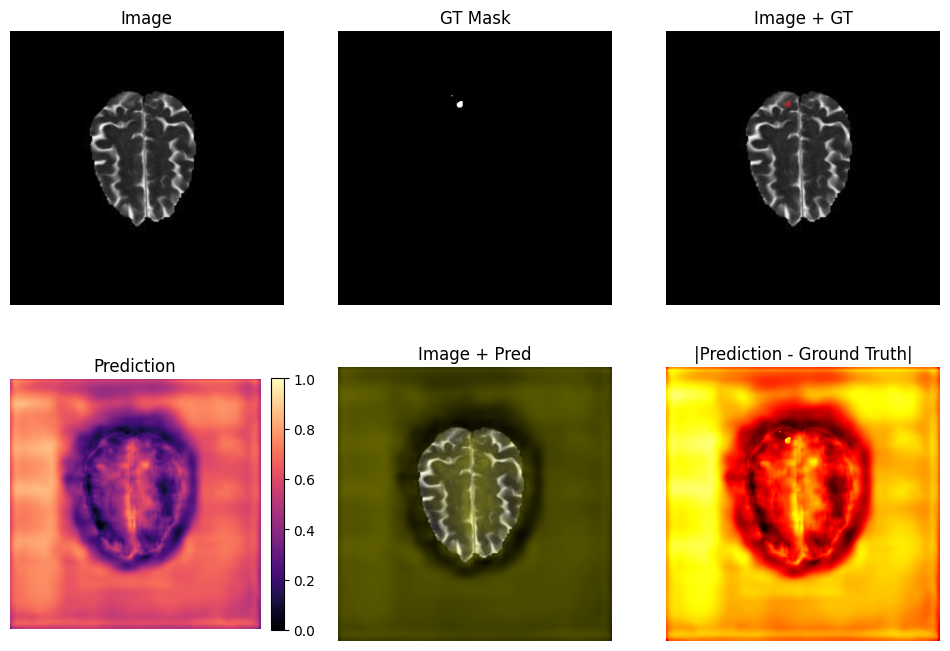

In [470]:
compute_test(args, model, num_workers, viz_k=20, k_shot='8')

In [182]:
torch.save(
    model.state_dict(),
    os.path.join(
        args.config.save_root,
        str(args.k_shot),
        f"full_dataset_whole_model.pth"
    )
)

### BEiT

In [ ]:
from transformers import BeitModel, SwinModel, AutoModel
enc = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")
# BEiT encoder's weights from ImageNet-22k
enc
from transformers import BeitConfig, UperNetConfig, UperNetForSemanticSegmentation

beit_backbone = BeitConfig(
    output_hidden_states=True,
    out_indices=[2, 5, 8, 11]   # can be tweaked
)
cfg = UperNetConfig(backbone_config=beit_backbone, num_labels=2)
model = UperNetForSemanticSegmentation(cfg)
# decoder's weights RANDOMLY INITIALIZED
model